In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.pyplot as plt
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
import bioframe
import bbi
import pyBigWig
from sklearn.isotonic import IsotonicRegression
# font_manager.fontManager.addfont('/cluster/home/futing/miniforge-pypy3/envs/hic/fonts/Arial.ttf')
# arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
import cooler
import hicstraw

## SNP import

In [2]:
#Project/GBM/HiC/13mutation/gbm_tcga_gdc/data_mutations.txt
SNP=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/gbm_cptac_2021/data_mutations.txt',sep='\t')
SNP['hg19id']=SNP['Chromosome']+'_'+SNP['Start_Position'].astype(str)+'_'+SNP['End_Position'].astype(str)
SNP['index']=range(2,len(SNP)+2)
SNP['Variant_Type'].value_counts()

Variant_Type
SNP    6240
DEL     340
INS      73
MNP      14
Name: count, dtype: int64

## 统计初始信息 
* SM 在样本中出现频次的分布（出现一次的SNP有几个，出现2次的有几个） 

* 样本中的SM数量的频次分布（含有一个SM的样本有几个，含有两个SM的样本有几个）   
    



In [3]:
# 每个SNP 在原始样本中出现频率的的分布
dupSNP=SNP.groupby('hg19id')['Tumor_Sample_Barcode'].count().sort_values(ascending=False).value_counts()
#pd.crosstab(df_long['ID'], df_long['Variable'])
# 每个样本中出现SNP的频率的分布
dupSample=SNP.groupby('Tumor_Sample_Barcode')['hg19id'].count().sort_values(ascending=False).value_counts()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


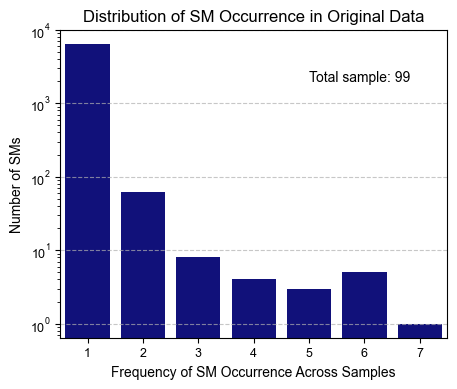

In [11]:
# 展示出现在一个样本的SM数量、出现在两个样本的SM数量、出现在三个样本的SM数量等
plt.figure(figsize=(5,4))
sns.barplot(x=dupSNP.index, y=dupSNP.values,color="darkblue")
plt.title("Distribution of SM Occurrence in Original Data", fontsize=12)
plt.xlabel("Frequency of SM Occurrence Across Samples", fontsize=10)
plt.ylabel("Number of SMs", fontsize=10)
plt.text(4, 2000, 'Total sample: 99', fontsize=10)
plt.yscale('log')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.savefig('SMinorin.pdf',dpi=300)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


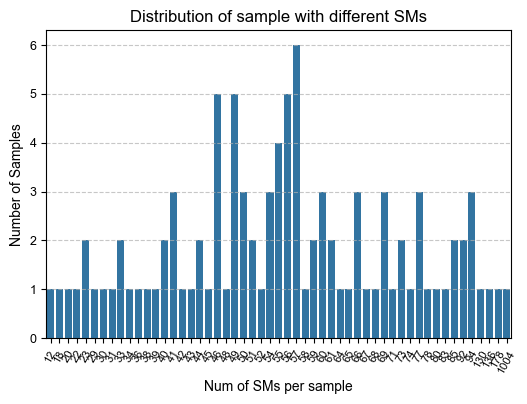

In [5]:
# 展示出现拥有一个SM的样本数量、拥有两个SM的样本数量、拥有三个SM的样本数量等

plt.figure(figsize=(6,4))
sns.barplot(x=dupSample.index, y=dupSample.values)
plt.title("Distribution of sample with different SMs", fontsize=12)
plt.xlabel("Num of SMs per sample", fontsize=10)
plt.ylabel("Number of Samples", fontsize=10)
#plt.text(4, 2000, 'Total SMs: 9654', fontsize=10)
plt.xticks(fontsize=8,rotation=60)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('nsample_diff_nSMs.pdf',dpi=300,bbox_inches='tight')

## Overlapped 的结果  
* Overlapped 的 SM 的数量与没有 overlapped 的 SM  

* 每个 Sample 中的 Overlapped SM 的比例

* SM 与 loop 的交集频率(与一个loop交集的SM有几个，与两个loop交集的SM有几个)

* overlapped SM 在样本中出现频次的分布（出现在一个样本的SM有几，出现两个样本的SMs有几个） 

* 样本中的 overlapped SM 数量的频次分布（含有一个SM的样本有几个，含有两个SM的样本有几个）   

In [4]:
# parirtobed 处理的数据
SM_loop=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/SM_loop_1k_fil.bedpe',sep='\t',header=None)
SM_loop.columns=['chr1','start1','end1','chr2','start2','end2','duplicated_loop','chr','start','end','index']


SM_loop_gene=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/SM_loop_1k_tss_gene.bedpe',sep='\t',header=None)
SM_loop_gene.drop(columns=[11, 12, 13, 15, 16], inplace=True)
SM_loop_gene.columns=['chr1','start1','end1','chr2','start2','end2','duplicated_loop','chr','start','end','index','ENSG','symbol','genetype']


# SM_loop_or=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/SM_loop.bedpe',sep='\t',header=None)
# SM_loop_or.columns=['chr1','start1','end1','chr2','start2','end2','duplicated_loop','chr','start','end','index']

In [124]:
SM_loop_gene['index'].nunique()

6667

In [5]:
# 有 loop gene 的数据
# 合并 int 转变为 float，因为数据中有 NA
SNP_loop_s=pd.merge(SM_loop_gene,SNP,on='index',how='outer')
SNP_loop_ss=SNP_loop_s.loc[:,['index','hg19id','Variant_Classification','Hugo_Symbol','Tumor_Sample_Barcode','dbSNP_RS','Variant_Type','chr1','start1','end1','chr2','start2','end2','chr','start','end','ENSG','symbol','genetype']]

SNP_loop_ss['loopid'] = np.where(
    SNP_loop_ss[['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2']].isna().any(axis=1),
    np.nan,  # 如果有任何 NA，则设置为 NA
    SNP_loop_ss['chr1'] + '_' + 
    (((SNP_loop_ss['start1'] + SNP_loop_ss['end1']) / 2).fillna(0).astype(int).astype(str)) + '_' +  # 计算中点，转换为 int 再转换为 str
    SNP_loop_ss['chr2'] + '_' + 
    (((SNP_loop_ss['start2'] + SNP_loop_ss['end2']) / 2).fillna(0).astype(int).astype(str))  # 同样处理
)


In [6]:
genebed=pd.read_csv('/cluster/home/futing/ref_genome/hg38_gencode/genebed/gencode.v43.gene.bed',sep='\t',header=None)
# genebed.drop(columns=[3,4,5,7,8],inplace=True)
genebed.columns=['chr','start','end','ENSG','dot','strand','symbol','type','biggertype']
genebed = genebed.drop_duplicates(subset=genebed.columns[6]).query('type == "protein_coding"')
genebed.drop(columns=['ENSG','dot','strand','type','biggertype'],inplace=True)

#### 检测 Hugo Symbol 和 hg19id 的位置关系

In [127]:
# 看一下 SM 文件里的 Hugo_Symbol 列作用
SNP_loop_ssg=pd.merge(SNP_loop_ss,genebed,left_on='Hugo_Symbol',right_on='symbol',how='left')
SNP_loop_ssg.loc[:,'inGene']=np.where(
    SNP_loop_ssg[['chr_y', 'start_y', 'end_y', 'symbol_y']].isna().any(axis=1),
    np.nan,  # 如果有任何 NA，则设置为 NA  发现有些基因没有匹配的位置信息
    np.where(
        (SNP_loop_ssg['start_x']>=SNP_loop_ssg['start_y']) & (SNP_loop_ssg['end_x']<=SNP_loop_ssg['end_y']),
        1,
        0
    )
)

In [128]:
# 发现 x1 x2 不一样
x1=SNP_loop_ssg[['hg19id','Hugo_Symbol','inGene']].drop_duplicates()
x2=SNP_loop_ssg[['hg19id','Hugo_Symbol']].drop_duplicates()
x2=x2.reindex(x1.index,fill_value=0)
x2.compare(x1.iloc[:,[0,1]]) # 发现有些基因有两个位置信息，所以有两个 inGene 信息

Empty DataFrame
Columns: []
Index: []

In [129]:
SNP_loop_ssg.loc[SNP_loop_ssg['hg19id']=='chr15_28948484_28948484',]

,index,hg19id,Variant_Classification,Hugo_Symbol,Tumor_Sample_Barcode,dbSNP_RS,Variant_Type,chr1,start1,end1,...,end_x,ENSG,symbol_x,genetype,loopid,chr_y,start_y,end_y,symbol_y,inGene
19014,2928,chr15_28948484_28948484,Missense_Mutation,GOLGA8M,C3L-02970,rs377742692,SNP,chr15,22580000.0,22610000.0,...,28703338,ENSG00000291261.1,ENSG00000291261,lncRNA,chr15_22595000_chr15_28715000,chr15,28698582.0,28738384.0,GOLGA8M,1.0
19015,2928,chr15_28948484_28948484,Missense_Mutation,GOLGA8M,C3L-02970,rs377742692,SNP,chr15,22580000.0,22610000.0,...,28703338,ENSG00000277515.1,RN7SL495P,misc_RNA,chr15_22595000_chr15_28715000,chr15,28698582.0,28738384.0,GOLGA8M,1.0
19016,2928,chr15_28948484_28948484,Missense_Mutation,GOLGA8M,C3L-02970,rs377742692,SNP,chr15,22580000.0,22610000.0,...,28703338,ENSG00000274632.1,RN7SL719P,misc_RNA,chr15_22595000_chr15_28715000,chr15,28698582.0,28738384.0,GOLGA8M,1.0


In [130]:
# hg19和Hugo_Symbol的对应关系
SNP_loop_ssgs=SNP_loop_ssg.loc[:,['hg19id','inGene','Hugo_Symbol','chr_x','start_x','end_x','chr_y','start_y','end_y']].drop_duplicates()
SNP_loop_ssgs['inGene'].value_counts().sum() #6534总共hg19id 6325个对应的Huget_Symbol是有注释

6325

In [131]:
SNP_loop_ssgs['inGene'].isna().sum() #209个没有匹配到基因的hg19id

209

In [ ]:
SNP_loop_ssgs['inGene'].value_counts() # 有四个不在基因上

inGene
1.0    6321
0.0       4
Name: count, dtype: int64

In [ ]:
# 看看不在基因内的 hg19id 和 Hugo_Symbol 是什么关系
SNP_loop_ssgs[SNP_loop_ssgs.loc[:,'inGene']==0.0]

,hg19id,inGene,Hugo_Symbol,chr_x,start_x,end_x,chr_y,start_y,end_y
5692,chr15_85360142_85360142,0.0,ALPK3,chr15,84816910,84816911,chr15,84817355.0,84873479.0
14563,chr1_13648278_13648278,0.0,PRAMEF15,chr1,12825319,12825320,chr1,13315580.0,13322598.0
21472,chr18_11644585_11644585,0.0,SLC35G4,chr18,11644585,11644586,chr18,11609595.0,11610612.0
21541,chr1_145302655_145302656,0.0,NBPF26,chr1,146135518,146135520,chr1,120723948.0,120842110.0


In [134]:
# 看不在基因内的SM与Hugo_Symbol的关系
# 使用 pd.notnull() 确保参与计算的列没有NA值
mask = (SNP_loop_ssgs['inGene'] == 0) & pd.notnull(SNP_loop_ssgs['end_x']) & pd.notnull(SNP_loop_ssgs['start_y']) & pd.notnull(SNP_loop_ssgs['start_x']) & pd.notnull(SNP_loop_ssgs['end_y'])

SNP_loop_ssgs.loc[mask, 'distance'] = np.where(
    SNP_loop_ssgs.loc[mask, 'end_x'] < SNP_loop_ssgs.loc[mask, 'start_y'],
    SNP_loop_ssgs.loc[mask, 'start_y'] - SNP_loop_ssgs.loc[mask, 'end_x'],
    SNP_loop_ssgs.loc[mask, 'start_x'] - SNP_loop_ssgs.loc[mask, 'end_y']
)

In [137]:
SNP_loop_ssgs['distance'].describe().apply(lambda x: f'{x:.2f}')

count           4.00
mean      6454521.25
std      12561244.89
min           444.00
25%         25590.75
50%        262116.50
75%       6691047.00
max      25293408.00
Name: distance, dtype: object

### 正常处理 SNP loop

In [7]:
# 合并 overlap 和原始数据
SNP_loop=pd.merge(SNP,SM_loop,on='index',how='outer')
#SNP_loop_or=pd.merge(SNP,SM_loop_or,on='index',how='outer')
# 截取有用的信息
SNP_loop_simple=SNP_loop.loc[:,['index','hg19id','Variant_Classification','Hugo_Symbol','Tumor_Sample_Barcode','dbSNP_RS','Variant_Type','chr1','start1','end1','chr2','start2','end2','chr','start','end']]
SNP_loop['hg19id'].unique().shape # 一共 6534 个SNP

(6534,)

In [19]:
SNP_loop_simple.loc[:,'score']=[1 if pd.notna(i) else 0 for i in SNP_loop_simple['chr1']] #chr1指示是否为loop

非零值的个数: 3660


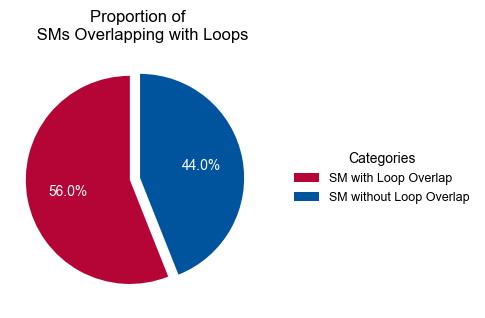

In [9]:
# Overlapped SM num VS Non-overlapped SM num

nonzero_count = (SNP_loop_simple.groupby('hg19id')['chr1'].count() > 0).sum() #6534
print("非零值的个数:", nonzero_count) #3723
zero_count = (SNP_loop_simple.groupby('hg19id')['chr1'].count() == 0).sum() # 6534-3660=2874

# 数据
labels = ['SM with Loop Overlap', 'SM without Loop Overlap']
sizes = [nonzero_count, zero_count]  # 各类别的数量
colors = ['#B40536','#00549E' ]  # 饼图的颜色
explode = (0.1, 0)  # 突出显示第一个类别

# 绘制饼图
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=None, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode,textprops={'color': 'white'})
plt.title('Proportion of \n SMs Overlapping with Loops', fontsize=12)
plt.legend(labels, loc='center left',bbox_to_anchor=(1.05, 0.5), fontsize=9, frameon=False, title="Categories", title_fontsize=10)
plt.tight_layout()
#plt.savefig('SM_loop_overlap.pSNP_loop_simple',dpi=300，bbox_inches='tight')

In [10]:
# SNP与loop交集的的频率 的分布（重叠1次的有多少个,重叠2次的有多少个，分开考虑不同样本的SNP）
#nloopedSM=pd.Series(SNP_loop_simple.loc[pd.notna(SNP_loop_simple['chr1']),'index'].value_counts().values).value_counts()
#nloopSM=SNP_loop_simple.groupby('index')['chr1'].count().value_counts()
nloopSM=SNP_loop_simple.groupby('hg19id')['chr1'].count().value_counts() #chr1 是 loop 的坐标，NA 表示没有loop
nloopSM_ss=SNP_loop_ss.groupby('hg19id')['loopid'].count().value_counts() #chr1 是 loop 的坐标，NA 表示没有loop

In [14]:
nloopSM.sum() # 6534

6534

In [15]:
# 看一下很多loop的SNP是什么样的
SNP_loop_simple.groupby('hg19id')['chr1'].count().sort_values(ascending=False)

hg19id
chr8_128752761_128752761    37
chr1_89449135_89449135      28
chr7_14758253_14758253      28
chr12_64825380_64825380     28
chr2_172571954_172571954    27
                            ..
chr3_151046084_151046084     0
chr3_155232647_155232647     0
chr3_15778657_15778657       0
chr3_160560076_160560076     0
chr3_178928057_178928058     0
Name: chr1, Length: 6534, dtype: int64

In [ ]:
# 详细的信息
SNP_loop_simple.loc[SNP_loop_simple['hg19id']=='chr2_172571954_172571954',:]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


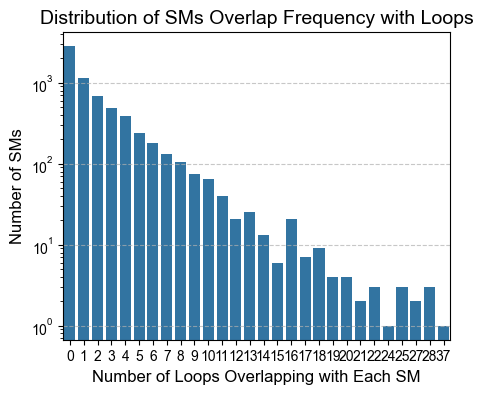

In [16]:

plt.figure(figsize=(5,4))
sns.barplot(x=nloopSM.index, y=nloopSM.values)
plt.title("Distribution of SMs Overlap Frequency with Loops", fontsize=14)
plt.xlabel("Number of Loops Overlapping with Each SM", fontsize=12)
plt.ylabel("Number of SMs", fontsize=12)
plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.savefig('nloop_perSM2.pdf',dpi=300,bbox_inches='tight')

In [20]:
# 统计每个 overlap SNP 在样本中出现的频率，然后统计这个频率的分布。即出现在一个样本的SNP有多少个，出现在两个样本的SNP有多少个

# loopscore=pd.crosstab(SNP_loop_simple_long['ID'], df_long['Variable'])
df_wide = SNP_loop_simple.pivot_table(index='Tumor_Sample_Barcode', columns='hg19id', values='score', aggfunc='sum') # 统计了每个样本中每个SNP出现的次数
df_wide.fillna(0, inplace=True)
snpsample=(df_wide>0).sum(axis=0).value_counts()#6534，大于0的个数（不是直接计算每列的和），再统计每列和的分布
snpsample1=SNP_loop_simple[SNP_loop_simple['score']!=0].groupby('hg19id')['Tumor_Sample_Barcode'].nunique().value_counts()#6534，只能先筛选出有loop的数据，然后再统计每列和的分布，这样会丢弃掉没有loop的样本
snpsample,snpsample1

(1    3619
 0    2874
 2      33
 3       4
 6       3
 7       1
 Name: count, dtype: int64,
 Tumor_Sample_Barcode
 1    3619
 2      33
 3       4
 6       3
 7       1
 Name: count, dtype: int64)

In [ ]:
snpsample1.sum(),snpsample.sum() # 3660, 6534,3723

(3660, 0)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


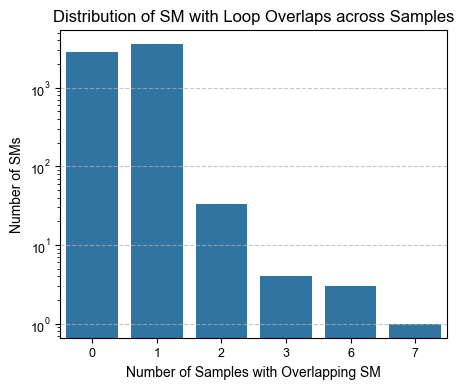

In [21]:
# 大部分的SNP只出现在一个样本中
plt.figure(figsize=(5,4))
sns.barplot(x=snpsample.index.astype(int), y=snpsample.values)
plt.title("Distribution of SM with Loop Overlaps across Samples", fontsize=12)
plt.xlabel("Number of Samples with Overlapping SM", fontsize=10)
plt.ylabel("Number of SMs", fontsize=10)
plt.yscale('log')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('noverlapSM_diff_nsample.pdf',dpi=300,bbox_inches='tight')

In [ ]:
# 统计拥有不同数量的SM的样本数量的分布，即多少样本有一个SM，多少样本有两个SM

samplesnp=(df_wide>0).sum(axis=1).value_counts().sort_index()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


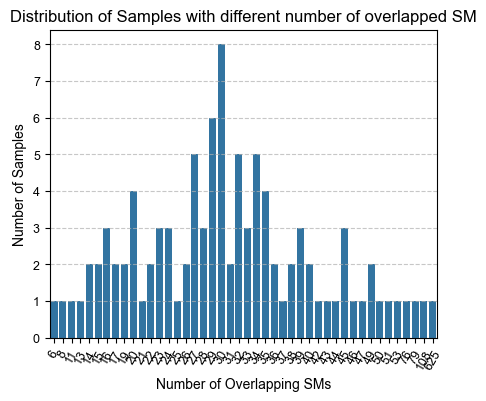

In [23]:
# 大部分样本都拥有overlapped SM

plt.figure(figsize=(5,4))
sns.barplot(x=samplesnp.index.astype(int), y=samplesnp.values)
plt.title("Distribution of Samples with different number of overlapped SM", fontsize=12)
plt.xlabel("Number of Overlapping SMs", fontsize=10)
plt.ylabel("Number of Samples", fontsize=10)

plt.xticks(fontsize=9,rotation=60)
plt.yticks(fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('nsample_diff_noverlapSM.pdf',dpi=300,bbox_inches='tight')

In [24]:
# 每个样本 overlaped SM 和 non-overlaped SM 的数量比例

# dupSample=SNP['Tumor_Sample_Barcode'].value_counts() # 有几个样本有重复的SM 这种方法不对
# SNP.loc[SNP['Tumor_Sample_Barcode']=='C3L-01887','hg19id'].duplicated().sum() #1

# 正确数量的方法，去掉每个样本中duplicated的SM
dupSample=SNP.groupby('Tumor_Sample_Barcode')['hg19id'].nunique() 
all_persample=SNP_loop_simple.groupby('Tumor_Sample_Barcode')['hg19id'].nunique()
# all_persample_aligned=all_persample.reindex(dupSample.index,fill_value=0) # 比较两种方法的结果
# all_persample_aligned.compare(dupSample,align_axis=0)

# 统计有score的SM的样本中，每个样本中有多少个SM
overlap_persample=SNP_loop_simple[SNP_loop_simple['score']>0].groupby('Tumor_Sample_Barcode')['hg19id'].nunique().reindex(all_persample.index,fill_value=0)

overlap_ratio=overlap_persample/all_persample
overlap_ratio=overlap_ratio.sort_values(ascending=False)

/tmp/ipykernel_50491/2998767917.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=overlap_ratio.index, y=overlap_ratio.values,palette=colors,edgecolor='black',linewidth=0.2)


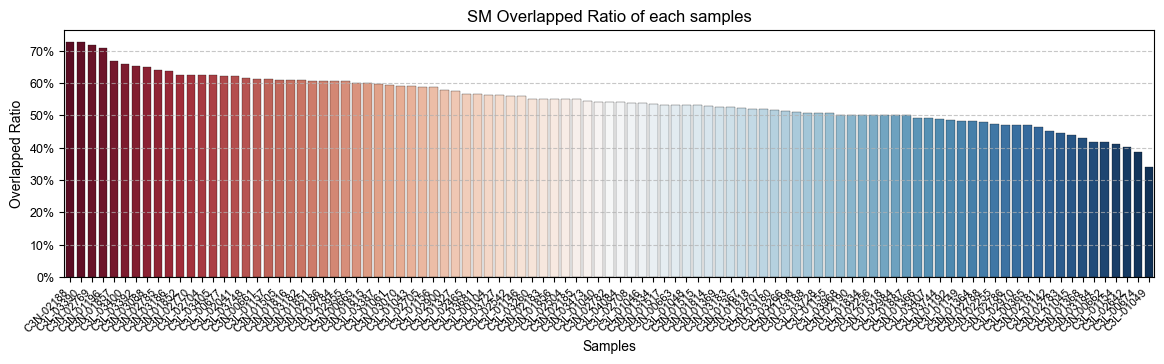

In [ ]:
# 统计每个样本大概有多少处于loop中的SM
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#16365F","#77A3BB","#F8F2ED","#D64F38"])
# colors = [custom_cmap(i / (len(overlap_ratio) - 1)) for i in range(len(overlap_ratio))]
colors = [plt.cm.RdBu(i / (len(overlap_ratio) - 1)) for i in range(len(overlap_ratio))]


plt.figure(figsize=(12,4))
sns.barplot(x=overlap_ratio.index, y=overlap_ratio.values,palette=colors,edgecolor='black',linewidth=0.2)



plt.title("SM Overlapped Ratio of each samples", fontsize=12)
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Overlapped Ratio", fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.xticks(ticks=range(len(overlap_ratio)), labels=overlap_ratio.index, fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=9)

# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
plt.tight_layout(pad=2.0)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.savefig('ploop_persample.pdf',dpi=300,bbox_inches='tight')


## gene load per SM

In [141]:
SNP_loop_ss.loc[:,'ENSG']=SNP_loop_ss['ENSG'].str.split('.').str[0]

In [142]:
symbol_matrix = SNP_loop_ss.pivot_table(
    index='Tumor_Sample_Barcode',
    columns='hg19id',
    values='symbol',
    aggfunc=lambda x: ' '.join(x.dropna().astype(str).unique())
)
symbol_matrix.head()

hg19id,chr10_100017842_100017842,chr10_100183413_100183413,chr10_100481428_100481428,chr10_100481448_100481448,chr10_101295226_101295226,chr10_101646280_101646280,chr10_101689847_101689847,chr10_101716420_101716420,chr10_102822720_102822720,chr10_102896495_102896495,...,chrX_99854068_99854068,chrX_99854625_99854625,chrY_23710716_23710716,chrY_23710825_23710825,chrY_3447670_3447670,chrY_3447809_3447809,chrY_4925071_4925071,chrY_4925496_4925496,chrY_5605441_5605441,chrY_9304672_9304672
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
C3L-00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00365,NaN,NaN,NaN,NaN,NaN,NaN,DNMBP-AS1 DNMBP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00677,NaN,ENSG00000230928 LOXL4 PYROXD2 MIR4685,NaN,NaN,NaN,NaN,NaN,DNMBP-AS1 DNMBP,ENSG00000236662 TWNK MRPL43 LZTS2 ENSG00000273...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-01040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TNMD,NaN,NaN,NaN,NaN,NaN,PCDH11Y,NaN,NaN,NaN


In [143]:
SMgene=SNP_loop_ss.loc[:,['hg19id','Tumor_Sample_Barcode','ENSG','symbol','genetype']]
#SNP_loop_simple['genetype']=='protein_coding'
SMgene.drop_duplicates(inplace=True)
SMgene.dropna(subset=['ENSG'],inplace=True)
SMgene.shape #10464 25268(21292 dropna)

(24806, 5)

In [34]:
SMgene.to_csv('SM_gene.csv',index=False,sep='\t')

In [144]:
SMgene.head()

,hg19id,Tumor_Sample_Barcode,ENSG,symbol,genetype
0,chr1_35227149_35227149,C3L-00104,ENSG00000189280,GJB5,protein_coding
1,chr1_35227149_35227149,C3L-00104,ENSG00000189433,GJB4,protein_coding
4,chr1_35227149_35227149,C3L-00104,ENSG00000188910,GJB3,protein_coding
5,chr1_35227149_35227149,C3L-00104,ENSG00000255811,ENSG00000255811,lncRNA
6,chr1_47276490_47276490,C3L-00104,ENSG00000142973,CYP4B1,protein_coding


## SM load per gene

In [8]:
SNP_loop_ss.head()

,index,hg19id,Variant_Classification,Hugo_Symbol,Tumor_Sample_Barcode,dbSNP_RS,Variant_Type,chr1,start1,end1,chr2,start2,end2,chr,start,end,ENSG,symbol,genetype,loopid
0,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33480000.0,33510000.0,chr1,34750000.0,34780000.0,chr1,34761547,34761548,ENSG00000189280.3,GJB5,protein_coding,chr1_33495000_chr1_34765000
1,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33480000.0,33510000.0,chr1,34750000.0,34780000.0,chr1,34761547,34761548,ENSG00000189433.7,GJB4,protein_coding,chr1_33495000_chr1_34765000
2,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33610000.0,33640000.0,chr1,34740000.0,34770000.0,chr1,34761547,34761548,ENSG00000189280.3,GJB5,protein_coding,chr1_33625000_chr1_34755000
3,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33610000.0,33640000.0,chr1,34740000.0,34770000.0,chr1,34761547,34761548,ENSG00000189433.7,GJB4,protein_coding,chr1_33625000_chr1_34755000
4,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33620000.0,33650000.0,chr1,34760000.0,34790000.0,chr1,34761547,34761548,ENSG00000188910.8,GJB3,protein_coding,chr1_33635000_chr1_34775000


In [9]:
SMload=SNP_loop_ss.groupby('symbol')['hg19id'].count().sort_values(ascending=False)

In [149]:
SNP_loop_ss.groupby('Hugo_Symbol')['hg19id'].count().sort_values(ascending=False)

Hugo_Symbol
ARMC5      447
PCDHB16    327
PCDHB10    276
NF1        261
PCDHB2     219
          ... 
ZNF813       1
ZNF850       1
ZNF98        1
ZP1          1
ZRSR2        1
Name: hg19id, Length: 4644, dtype: int64

In [ ]:
RNAexp=pd.read_csv('/cluster/home/futing/Project/GBM/RNA/merge/merged_RNA.txt',sep="\t")
summary=pd.read_csv("/cluster/home/futing/Project/GBM/RNA/merge/summary.txt",sep="\t",index_col=0)
id=summary.loc[summary['kmeans'].notna(),'id']

In [26]:
RNAexp_fil=RNAexp.loc[RNAexp.index.isin(id),:]

In [33]:
RNAexp_filmean=RNAexp_fil.mean(axis=0)
RNAexp_filmean.name = "RNAexp"
SMload.name = "SMload"


In [32]:
print(type(RNAexp_filmean))
print(type(SMload))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [34]:
corRNA=pd.merge(RNAexp_filmean,SMload,left_index=True,right_index=True,how='inner')

In [37]:
from scipy.stats import zscore
corRNA['zscoreRNA']=zscore(corRNA['RNAexp'])

In [40]:
corRNA['RNAexp'].corr(corRNA['SMload'])

0.0035342558617231304

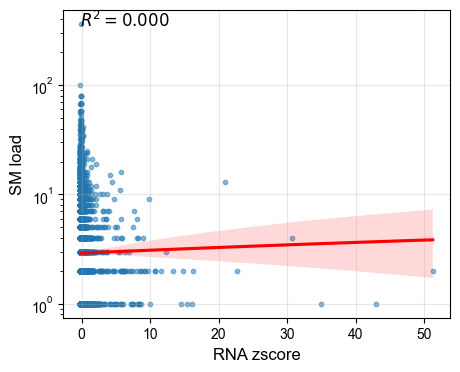

In [42]:
from scipy.stats import linregress
# 回归线
x = corRNA['zscoreRNA']
y = corRNA['SMload']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red'})

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=12, color='black'
)

# 设置标题和标签
#plt.title('Scatter plot with regression line', fontsize=15)
plt.xlabel('RNA zscore', fontsize=12)
plt.ylabel('SM load', fontsize=12)
plt.yscale('log')
plt.grid(alpha=0.3)

## 获取 SM 附近的Hi-C contact，添加为score

In [35]:
SNP_loop_simple=SNP_loop_simple.fillna(np.nan)
SNP_loop_simple.apply(lambda x: type(x[0]))

index                       <class 'numpy.int64'>
hg19id                              <class 'str'>
Variant_Classification              <class 'str'>
Hugo_Symbol                         <class 'str'>
Tumor_Sample_Barcode                <class 'str'>
dbSNP_RS                            <class 'str'>
Variant_Type                        <class 'str'>
chr1                                <class 'str'>
start1                    <class 'numpy.float64'>
end1                      <class 'numpy.float64'>
chr2                                <class 'str'>
start2                    <class 'numpy.float64'>
end2                      <class 'numpy.float64'>
chr                                 <class 'str'>
start                     <class 'numpy.float64'>
end                       <class 'numpy.float64'>
ENSG                                <class 'str'>
symbol                              <class 'str'>
genetype                            <class 'str'>
dtype: object

In [ ]:
#SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),['start1','end1','start2','end2','start','end']]=SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),['start1','end1','start2','end2','start','end']].astype(int)

SNP_loop_simple[SNP_loop_simple.select_dtypes(include=['float64']).columns] = SNP_loop_simple.select_dtypes(include=['float64']).astype('Int64')
#SNP_loop_simple.to_csv('SNP_loop_simple.bed',index=False,sep='\t')

In [6]:
SNP_loop_simple=pd.read_csv('SNP_loop_simple_id.bed',sep='\t')

In [7]:
SNP_loop_simple.head()

,index,hg19id,Variant_Classification,Hugo_Symbol,Tumor_Sample_Barcode,dbSNP_RS,Variant_Type,chr1,start1,end1,chr2,start2,end2,chr,start,end,score,bin1,bin2
0,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33480000.0,33510000.0,chr1,34750000.0,34780000.0,chr1,34761547.0,34761548.0,1,3349.0,3476.0
1,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33610000.0,33640000.0,chr1,34740000.0,34770000.0,chr1,34761547.0,34761548.0,1,3362.0,3475.0
2,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33620000.0,33650000.0,chr1,34760000.0,34790000.0,chr1,34761547.0,34761548.0,1,3363.0,3477.0
3,3,chr1_47276490_47276490,Missense_Mutation,CYP4B1,C3L-00104,rs200083913,SNP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,4,chr1_91841089_91841089,Missense_Mutation,HFM1,C3L-00104,novel,SNP,chr1,91370000.0,91400000.0,chr1,156200000.0,156230000.0,chr1,91375531.0,91375532.0,1,9138.0,15621.0


In [ ]:
GBM=cooler.Cooler("/cluster/home/futing/Project/GBM/HiC/02data/03cool/10000/GBM_10000.cool")
A172=cooler.Cooler("/cluster/home/futing/Project/GBM/HiC/02data/03cool/10000/A172_10000.cool")


In [ ]:
# GBM_pixels=GBM.pixels(join=True)[:].iloc[:100,:]
# GBM.matrix(balance=True)[:]
# 读不了

In [279]:
A172_bins=A172.bins()[:]

In [322]:
A172_bins.head()
bins=A172_bins
chr1='chr1'
start1=33480000	
end1=33510000
chr2='chr1'
start2=34750000
end2=34780000

In [323]:
get_binid(chr1,start1,end1,chr2,start2,end2)

(3349, 3476)

In [ ]:
def get_binid(chr,start,end,bins=A):

In [326]:
def get_binid(chr1,start1,end1,chr2,start2,end2,bins=A172_bins):
    startmid1=(start1+end1)//2
    startmid2=(start2+end2)//2
    bin1=bins[(bins['chrom']==chr1) & (bins['start']<=startmid1) & (bins['end']>=startmid1)]
    bin2=bins[(bins['chrom']==chr2) & (bins['start']<=startmid2) & (bins['end']>=startmid2)]
    if bin1.empty or bin2.empty:
        return None, None  # 如果找不到匹配的bin，返回None
    return bin1.index[0],bin2.index[0]

In [327]:
SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),'bin1'], SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),'bin2'] = zip(*SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),:].apply(
    lambda x: get_binid(x['chr1'], x['start1'], x['end1'], x['chr2'], x['start2'], x['end2']), axis=1))


In [329]:
SNP_loop_simple.head()

,index,hg19id,Variant_Classification,Hugo_Symbol,Tumor_Sample_Barcode,dbSNP_RS,Variant_Type,chr1,start1,end1,chr2,start2,end2,chr,start,end,score,bin1,bin2
0,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33480000,33510000,chr1,34750000,34780000,chr1,34761547,34761548,1,3349.0,3476.0
1,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33610000,33640000,chr1,34740000,34770000,chr1,34761547,34761548,1,3362.0,3475.0
2,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33620000,33650000,chr1,34760000,34790000,chr1,34761547,34761548,1,3363.0,3477.0
3,3,chr1_47276490_47276490,Missense_Mutation,CYP4B1,C3L-00104,rs200083913,SNP,NaN,<NA>,<NA>,NaN,<NA>,<NA>,NaN,<NA>,<NA>,0,NaN,NaN
4,4,chr1_91841089_91841089,Missense_Mutation,HFM1,C3L-00104,novel,SNP,chr1,91370000,91400000,chr1,156200000,156230000,chr1,91375531,91375532,1,9138.0,15621.0


In [324]:
SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),'bin1'],SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),'bin2']=SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),:].apply(lambda x: get_binid(x['chr1'],x['start1'],x['end1'],x['chr2'],x['start2'],x['end2']),axis=1)

ValueError: too many values to unpack (expected 2)

In [330]:
SNP_loop_simple.to_csv('SNP_loop_simple_id.bed',index=False,sep='\t')

In [ ]:
SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),'bin']=SNP_loop_simple.loc[SNP_loop_simple['chr'].notna(),:].apply(lambda x: get_binid(x['chr'],x['start'],x['end']),axis=1)

0    3476
dtype: int64

In [ ]:
#308837
def get_contact(chr1,chr2,start1,end1,start2,end2,GBM=A172):
    return A172.matrix(balance=True).fetch(chr1,start1,end1,chr2,start2,end2)

In [278]:
A172.matrix()[:].shape

MemoryError: Unable to allocate 355. GiB for an array with shape (308837, 308837) and data type int32

In [ ]:
A172.matrix(balance=True).fetch('chr1',0,1000000,'chr1',0,1000000)

In [ ]:
SNP_loop_simple['contact']=SNP_loop_simple.apply(lambda x: get_contact(x['chr1'],x['chr2'],x['start1'],x['end1'],x['start2'],x['end2']),axis=1)

## 合并 SNP occurence 与 meta

In [81]:
meta=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation/gbm_cptac_2021_meta.bed',sep='\t')
print(meta.columns)
print(meta['PATIENT_ID'].isin(SNP['Tumor_Sample_Barcode'].unique()).sum())

Index(['PATIENT_ID', 'AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'BMI',
       'COUNTRY_OF_ORIGIN', 'RACE', 'ETHNICITY', 'ETHNICITY_SELF_IDENTIFY',
       'SMOKING_HISTORY', 'SECONDHAND_SMOKE_EXPOSURE', 'FOLLOW_UP_PERIOD',
       'VITAL_STATUS', 'PATH_DIAG_TO_LAST_CONTACT_DAYS',
       'PATH_DIAG_TO_DEATH_DAYS', 'CAUSE_OF_DEATH', 'LOST_TO_FOLLOW_UP',
       'TUMOR_REOCCUR_AFTER_TREATMENT', 'PATH_DIAG_TO_TUMOR_REOCCUR_DAYS',
       'EXPERT_PATH_REVIEW', 'EXPERT_PATH_REVIEW_NUM_SEGMENTS',
       'EXPERT_PATH_REVIEW_DETAILS', 'EXCLUDED_IN_DOWNSTREAM_ANALYSIS'],
      dtype='object')
99


### Overlapped loop的数据

In [82]:
#loopscore=pd.crosstab(df_long['ID'], df_long['Variable'])
df_wide = SNP_loop_simple.pivot_table(index='Tumor_Sample_Barcode', columns='hg19id', values='score', aggfunc='sum')
df_wide.head()

hg19id,chr10_100017842_100017842,chr10_100183413_100183413,chr10_100481428_100481428,chr10_100481448_100481448,chr10_101295226_101295226,chr10_101646280_101646280,chr10_101689847_101689847,chr10_101716420_101716420,chr10_102822720_102822720,chr10_102896495_102896495,...,chrX_99854068_99854068,chrX_99854625_99854625,chrY_23710716_23710716,chrY_23710825_23710825,chrY_3447670_3447670,chrY_3447809_3447809,chrY_4925071_4925071,chrY_4925496_4925496,chrY_5605441_5605441,chrY_9304672_9304672
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
C3L-00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00365,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00677,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C3L-01040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [ ]:
# 去掉不出现在任何样本的SM
df_wide=df_wide.loc[:,df_wide.sum()>0]
# 截取无用的信息
meta_simple=meta.loc[:,['PATIENT_ID','PATH_DIAG_TO_DEATH_DAYS','PATH_DIAG_TO_LAST_CONTACT_DAYS','CAUSE_OF_DEATH','VITAL_STATUS','LOST_TO_FOLLOW_UP']]
meta_simple.head()

Index(['chr10_100017842_100017842', 'chr10_100183413_100183413',
       'chr10_102822720_102822720', 'chr10_102896495_102896495',
       'chr10_103354446_103354446', 'chr10_103988859_103988859',
       'chr10_103988978_103988978', 'chr10_104136788_104136788',
       'chr10_104244012_104244012', 'chr10_104836841_104836841',
       ...
       'chrX_70617205_70617205', 'chrX_70888389_70888389',
       'chrX_71351111_71351111', 'chrX_71360195_71360195',
       'chrX_77286909_77286909', 'chrX_77372817_77372817',
       'chrX_79698737_79698737', 'chrX_84329296_84329296',
       'chrX_84363728_84363728', 'chrX_99663212_99663212'],
      dtype='object', name='hg19id', length=3660)

In [231]:
# 合并Meta和Overlapped SM的信息
overlapmeta=pd.merge(meta_simple,df_wide,left_on='PATIENT_ID',right_index=True,how='inner')
overlapmeta['PATH_DIAG_TO_LAST_CONTACT_DAYS'].isna().sum()

overlapmeta=overlapmeta.loc[~overlapmeta['PATH_DIAG_TO_LAST_CONTACT_DAYS'].isna(),] #metadat中有两个没有信息
overlapmeta.iloc[:,6:]=overlapmeta.iloc[:,6:].fillna(0)
#overlapmeta.to_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/mutation/patient_loop.csv',index=False)

In [232]:
overlapmeta.loc[:,'sum']=overlapmeta.iloc[:,6:].sum(axis=1)
overlapmeta.loc[:,['PATH_DIAG_TO_DEATH_DAYS','sum']].corr(method='spearman')

,PATH_DIAG_TO_DEATH_DAYS,sum
PATH_DIAG_TO_DEATH_DAYS,1.000000,0.165474
sum,0.165474,1.000000


In [ ]:
# 合并overlapped nonNA的SM的数量、原始的nonNA的SM的数量
overlapmeta=pd.merge(overlapmeta,all_persample,left_on='PATIENT_ID',right_index=True,how='inner')
overlapmeta.loc[:,'nonNAnum']=overlapmeta.iloc[:,6:-3].apply(lambda x: x[x>0].count(),axis=1)
overlapmeta['ratio']=overlapmeta['sum']/overlapmeta['hg19id']

In [244]:
overlapmeta.loc[:,['PATH_DIAG_TO_DEATH_DAYS','ratio']].corr(method='pearson')

,PATH_DIAG_TO_DEATH_DAYS,ratio
PATH_DIAG_TO_DEATH_DAYS,1.000000,0.174149
ratio,0.174149,1.000000


In [240]:
overlapmeta.loc[:,['PATH_DIAG_TO_DEATH_DAYS','ratio']].corr(method='spearman')

,PATH_DIAG_TO_DEATH_DAYS,ratio
PATH_DIAG_TO_DEATH_DAYS,1.000000,0.138695
ratio,0.138695,1.000000


In [ ]:
# 看一看特别的样本，第三行的样本，sum是最大的，同时发现这个样本的SM最多
overlapmeta.iloc[3,6:-1].sort_values(ascending=False).head(10)

chr20_47244450_47244450     25.0
chr17_70120390_70120395     24.0
chr2_189393834_189393835    22.0
chr12_94543187_94543187     22.0
chr1_61798253_61798254      20.0
chr1_184675818_184675818    19.0
chr7_138444565_138444565    18.0
chr16_31477459_31477459     18.0
chr16_31475849_31475849     18.0
chrX_11162228_11162228      17.0
Name: 3, dtype: object

In [245]:
overlapmeta.iloc[:,-5:]

,chrX_99663212_99663212,sum,hg19id,nonNAnum,ratio
0,0.0,165.0,78,44,2.115385
1,0.0,123.0,66,31,1.863636
2,0.0,63.0,44,17,1.431818
3,3.0,2344.0,1004,624,2.334661
4,0.0,168.0,94,51,1.787234
...,...,...,...,...,...
94,0.0,74.0,38,20,1.947368
95,0.0,37.0,36,15,1.027778
96,0.0,156.0,66,42,2.363636
97,0.0,121.0,57,29,2.122807


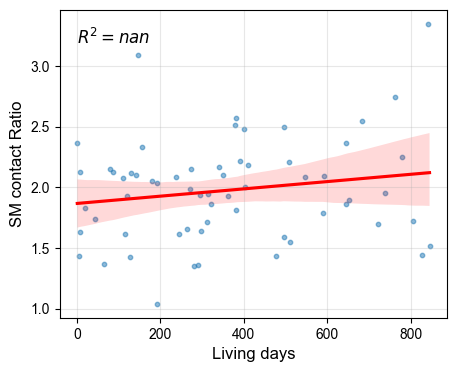

In [239]:
from scipy.stats import linregress
# 回归线
x = overlapmeta['PATH_DIAG_TO_DEATH_DAYS']
y = overlapmeta['ratio']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
r_squared = r_value**2  # 计算 R^2 值

# 绘制散点图和回归线
plt.figure(figsize=(5, 4))
sns.regplot(x=x, y=y, scatter_kws={'s': 10, 'alpha': 0.5}, line_kws={'color': 'red'})

# 添加 R^2 值到图中
plt.text(
    x.min(), y.max() * 0.95,  # 文本位置
    f'$R^2 = {r_squared:.3f}$',  # 格式化 R^2
    fontsize=12, color='black'
)

# 设置标题和标签
#plt.title('Scatter plot with regression line', fontsize=15)
plt.xlabel('Living days', fontsize=12)
plt.ylabel('SM contact Ratio', fontsize=12)
plt.grid(alpha=0.3)

In [241]:
overlapmeta.to_csv('/cluster/home/futing/Project/GBM/HiC/13mutation/2021.csv',index=False)

### 原始数据

In [218]:
# 原始数据，每个样本中SM出现的次数

orin=pd.crosstab(SNP['Tumor_Sample_Barcode'], SNP['hg19id']).gt(0).astype(int)
#orin=SNP.pivot_table(index='Tumor_Sample_Barcode',columns='hg19id',aggfunc=lambda x: 1, fill_value=0)
metaorin=pd.merge(meta_simple.iloc[:,:6],orin,left_on='PATIENT_ID',right_index=True,how='inner')

In [220]:
metaorin['sum']=metaorin.iloc[:,6:].sum(axis=1)
metaorin.loc[:,['PATH_DIAG_TO_DEATH_DAYS','sum']].corr(method='spearman')

,PATH_DIAG_TO_DEATH_DAYS,sum
PATH_DIAG_TO_DEATH_DAYS,1.000000,0.069639
sum,0.069639,1.000000


In [202]:
SMsum=metaorin.iloc[:,[0,-1]].sort_values(by='sum',ascending=False).head(10)

In [221]:
metaorin.head()

,PATIENT_ID,PATH_DIAG_TO_DEATH_DAYS,PATH_DIAG_TO_LAST_CONTACT_DAYS,CAUSE_OF_DEATH,VITAL_STATUS,LOST_TO_FOLLOW_UP,chr10_100017842_100017842,chr10_100183413_100183413,chr10_100481428_100481428,chr10_100481448_100481448,...,chrX_99854625_99854625,chrY_23710716_23710716,chrY_23710825_23710825,chrY_3447670_3447670,chrY_3447809_3447809,chrY_4925071_4925071,chrY_4925496_4925496,chrY_5605441_5605441,chrY_9304672_9304672,sum
0,C3L-00104,129.0,128.0,NaN,Deceased,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,78
1,C3L-00365,322.0,280.0,NaN,Deceased,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,66
2,C3L-00674,478.0,385.0,GBM,Deceased,No,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44
3,C3L-00677,155.0,155.0,GBM,Deceased,No,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1004
4,C3L-01040,NaN,608.0,NaN,Living,Yes,0,0,0,0,...,0,0,0,0,0,1,0,0,0,94


### non-overlapped SM   
从上面得到的数据

In [ ]:
# 每个 sample 的 non overlap SM的的数量
nonoverlap=all_persample-overlap_persample

In [201]:
all_persample,overlap_persample,nonoverlap

(Tumor_Sample_Barcode
 C3L-00104      78
 C3L-00365      66
 C3L-00674      44
 C3L-00677    1004
 C3L-01040      94
              ... 
 C3N-03183      38
 C3N-03184      36
 C3N-03186      66
 C3N-03188      57
 C3N-03473      55
 Name: hg19id, Length: 99, dtype: int64,
 Tumor_Sample_Barcode
 C3L-00104     44
 C3L-00365     31
 C3L-00674     17
 C3L-00677    625
 C3L-01040     51
             ... 
 C3N-03183     20
 C3N-03184     15
 C3N-03186     42
 C3N-03188     29
 C3N-03473     30
 Name: hg19id, Length: 99, dtype: int64,
 Tumor_Sample_Barcode
 C3L-00104     34
 C3L-00365     35
 C3L-00674     27
 C3L-00677    379
 C3L-01040     43
             ... 
 C3N-03183     18
 C3N-03184     21
 C3N-03186     24
 C3N-03188     28
 C3N-03473     25
 Name: hg19id, Length: 99, dtype: int64)

In [199]:
nonoverlap.head()

Tumor_Sample_Barcode
C3L-00104     34
C3L-00365     35
C3L-00674     27
C3L-00677    379
C3L-01040     43
Name: hg19id, dtype: int64

## SM load of Patient

In [91]:
SNP_loop_ss.head()

,index,hg19id,Variant_Classification,Hugo_Symbol,Tumor_Sample_Barcode,dbSNP_RS,Variant_Type,chr1,start1,end1,chr2,start2,end2,chr,start,end,ENSG,symbol,genetype,loopid
0,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33480000.0,33510000.0,chr1,34750000.0,34780000.0,chr1,34761547.0,34761548.0,ENSG00000189280.3,GJB5,protein_coding,chr1_33495000_chr1_34765000
1,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33480000.0,33510000.0,chr1,34750000.0,34780000.0,chr1,34761547.0,34761548.0,ENSG00000189433.7,GJB4,protein_coding,chr1_33495000_chr1_34765000
2,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33610000.0,33640000.0,chr1,34740000.0,34770000.0,chr1,34761547.0,34761548.0,ENSG00000189280.3,GJB5,protein_coding,chr1_33625000_chr1_34755000
3,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33610000.0,33640000.0,chr1,34740000.0,34770000.0,chr1,34761547.0,34761548.0,ENSG00000189433.7,GJB4,protein_coding,chr1_33625000_chr1_34755000
4,2,chr1_35227149_35227149,Silent,GJB4,C3L-00104,rs199643649,SNP,chr1,33620000.0,33650000.0,chr1,34760000.0,34790000.0,chr1,34761547.0,34761548.0,ENSG00000188910.8,GJB3,protein_coding,chr1_33635000_chr1_34775000


In [ ]:
SNP_loop_ssg.loc[SNP_loop_ssg['inGene'],['chr_x', 'start_x', 'end_x','chr_y', 'start_y', 'end_y',
       'symbol_y','Hugo_Symbol', 'inGene']].head()

,chr_x,start_x,end_x,chr_y,start_y,end_y,symbol_y,Hugo_Symbol,inGene
0,chr1,34761547.0,34761548.0,chr1,34759739.0,34762327.0,GJB4,GJB4,1.0
1,chr1,34761547.0,34761548.0,chr1,34759739.0,34762327.0,GJB4,GJB4,1.0
2,chr1,34761547.0,34761548.0,chr1,34759739.0,34762327.0,GJB4,GJB4,1.0
3,chr1,34761547.0,34761548.0,chr1,34759739.0,34762327.0,GJB4,GJB4,1.0
4,chr1,34761547.0,34761548.0,chr1,34759739.0,34762327.0,GJB4,GJB4,1.0


## Loop 

In [ ]:
loop=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/consensus/result/all/GBMfil_merged.bed',sep='\t')

In [ ]:
loop.head()

,chr,start,end,P455.SF11901,P475.SF12180,P498.SF12251,P503.SF12518,P519.SF12601,P521.SF12631,P524.SF12681v1,...,U343,U87,G523,G567,G583,U251,H4,42MGBA,num,NonNA_Count
0,chr1,775000,855000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,chr1,785000,224045000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,15
2,chr1,825000,224015000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,chr1,895000,5665000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
4,chr1,905000,975000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,9


In [ ]:
loop.columns

Index(['chr', 'start', 'end', 'P455.SF11901', 'P475.SF12180', 'P498.SF12251',
       'P503.SF12518', 'P519.SF12601', 'P521.SF12631', 'P524.SF12681v1',
       'P524.SF12681v4', 'P524.SF12681v9', 'P529.SF12794v1-1',
       'P529.SF12794v6-1', 'P529.SF12794v8-1', 'P530.SF12822v10',
       'P530.SF12822v13', 'P530.SF12822v14', 'P530.SF12822v15',
       'P530.SF12822v18', 'P530.SF12822v19', 'P530.SF12822v2',
       'P530.SF12822v4', 'P530.SF12822v5', 'G1', 'G23', 'G28', 'G61', 'G62',
       'G83', 'G120', 'G148', 'G163', 'G171', 'G181', 'G208', 'G213', 'G275',
       'G275R', 'G318', 'G323', 'G351', 'G390', 'G394', 'G402', 'G402R',
       'G412', 'G412R', 'G450', 'G452C', 'G452P', 'G457', 'A172', 'SW1088',
       'U118', 'U343', 'U87', 'G523', 'G567', 'G583', 'U251', 'H4', '42MGBA',
       'num', 'NonNA_Count'],
      dtype='object')

In [ ]:
nloop=loop['NonNA_Count'].value_counts()
nloop.index,nloop.values

(Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 21, 20, 22, 24, 25, 23, 27, 26, 29, 28, 30, 31, 33, 32, 34, 36, 35,
        39, 42, 37, 44, 40, 41, 47, 45, 48, 38, 43, 46, 50, 49, 51, 53, 54, 52,
        56, 55, 57, 58, 59, 60],
       dtype='int64', name='NonNA_Count'),
 array([80366, 24484, 13761,  9067,  6552,  4995,  4016,  3302,  2717,
         2292,  2022,  1766,  1517,  1357,  1218,  1101,  1038,   940,
          828,   766,   728,   644,   602,   598,   593,   493,   465,
          459,   454,   416,   385,   366,   352,   337,   330,   320,
          304,   291,   285,   280,   278,   272,   269,   256,   251,
          247,   242,   237,   214,   208,   196,   192,   191,   189,
          165,   156,   118,    65,    39,    13]))

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/tmp/ipykernel_10724/2897715124.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nloop.index, y=nloop.values, palette="viridis")
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


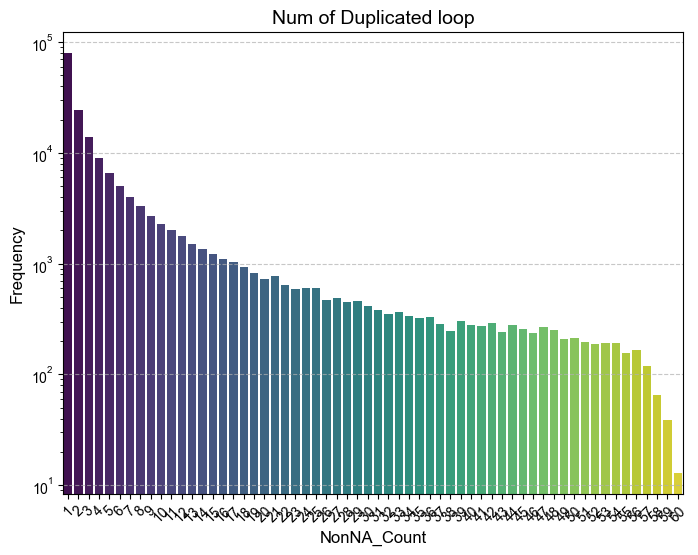

In [ ]:

plt.figure(figsize=(8, 6))
sns.barplot(x=nloop.index, y=nloop.values)
plt.title("Num of Duplicated loop", fontsize=14)
plt.xlabel("NonNA_Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)